# Aspen Community Clustering Project

This notebook documents the development and evaluation process of a clustering algorithm with the goal of confidently classifying a GitHub project into a 'stage of maturity'.

Current focus areas: 

* Expanding feature set
* Identifying important features 
* Identifying optimal number of clusters

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
import json
import sqlalchemy as salc
from google.colab import drive
import pandas as pd
from time import gmtime
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.decomposition import PCA
from statistics import mean 
import datetime
import seaborn as sns

In [3]:
with open("copy_cage-padres.json") as config_file: # MS changed path from ../comm_cage.json
    config = json.load(config_file)

In [4]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Feature Engineering
Augur Schema : https://oss-augur.readthedocs.io/en/main/schema/overview.html

In [6]:
repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated, 
              r.committers_count as committers,
              r.commit_count as commits,
              CASE WHEN r.committers_count > 0 THEN r.commit_count / r.committers_count ELSE 0 END AS commits_per_committer,
              r.pull_requests_open as prs_open,
              r.pull_requests_closed as prs_closed,
              r.pull_requests_merged as prs_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count as forks,
              r.license_file as license, 
              r.code_of_conduct_file as coc, 
              r.stars_count as stars,
              r.watchers_count as watchers, 
              r.issues_enabled,
              (SELECT AVG(c.cmt_added) FROM commits c WHERE c.repo_id = b.repo_id) AS avg_commit_length,
              (SELECT AVG(i.comment_count) FROM issues i WHERE i.repo_id = b.repo_id) AS avg_i_comment_count,
              AVG(DATE_PART('hour',pr.pr_closed_at - pr.pr_created_at)) as avg_time_to_close,
              AVG(DATE_PART('hour',pr.pr_merged_at - pr.pr_created_at)) as avg_time_to_merge,
              (SELECT AVG(commit_count) AS avg_commits_per_pr
         FROM (SELECT pr.pull_request_id, COUNT(prc.pr_cmt_id) AS commit_count
               FROM pull_request_commits prc
               JOIN pull_requests pr ON prc.pull_request_id = pr.pull_request_id
               WHERE pr.repo_id = b.repo_id
               GROUP BY pr.pull_request_id
              ) AS pr_commits
        ) AS avg_commits_per_pr
          FROM repo_groups a
          JOIN repo b ON a.repo_group_id = b.repo_group_id
          JOIN repo_info r ON r.repo_id = b.repo_id AND r.repo_info_id = (
              SELECT MAX(r2.repo_info_id)
              FROM repo_info r2
              WHERE r2.repo_id = b.repo_id
          )
          LEFT JOIN pull_requests pr ON pr.repo_id = b.repo_id
          GROUP BY
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated,
              r.committers_count,
              r.commit_count,
              r.pull_requests_open,
              r.pull_requests_closed,
              r.pull_requests_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count,
              r.license_file,
              r.code_of_conduct_file,
              r.stars_count,
              r.watchers_count,
              r.issues_enabled

""")

repos = pd.read_sql(repo_query, con=engine)
repos = repos.fillna(0) # change NaN values to 0
display(repos)
repos.dtypes

rg_name  repo_group_id                   repo_name  repo_id  \
0      Default Repo Group             10                 update-test    25430   
1      Default Repo Group             10  grimoirelab-perceval-opnfv    25445   
2      Default Repo Group             10        grimoirelab-hatstall    25450   
3       Anaconda-Platform          25430            anaconda-project    25431   
4       Anaconda-Platform          25430                     support    25432   
...                   ...            ...                         ...      ...   
11577       thoth-station         100119                        help    61720   
11578       thoth-station         100119       thoth-pre-commit-hook    61721   
11579       thoth-station         100119            ttm-as-a-service    61722   
11580       thoth-station         100119            opendatahub-cnbi    61723   
11581       thoth-station         100119               odh-dashboard    61724   

             last_updated  committers  commits  commits_per_committer  \
0     2021-10-07 20:45:41           1      0.0                    0.0   
1     2022-02-14 12:27:31          10    172.0                   17.0   
2     2022-10-27 14:46:09           9    195.0                   21.0   
3     2023-01-15 04:50:21          19   1795.0                   94.0   
4     2021-12-19 01:16:12           2      9.0                    4.0   
...                   ...         ...      ...                    ...   
11577 2022-05-02 12:53:03           4     69.0                   17.0   
11578 2022-11-01 20:28:03           6     53.0                    8.0   
11579 2022-09-14 14:07:22           5      0.0                    0.0   
11580 2022-11-07 20:41:23           6      0.0                    0.0   
11581 2022-10-21 08:37:50          29      0.0                    0.0   

       prs_open  prs_closed  ...                                      license  \
0             0           0  ...      http://choosealicense.com/licenses/mit/   
1             0          10  ...  http://choosealicense.com/licenses/gpl-3.0/   
2             3          10  ...  http://choosealicense.com/licenses/gpl-3.0/   
3             5          14  ...    http://choosealicense.com/licenses/other/   
4             0           0  ...                                            0   
...         ...         ...  ...                                          ...   
11577         0           5  ...  http://choosealicense.com/licenses/gpl-3.0/   
11578         1           0  ...  http://choosealicense.com/licenses/gpl-3.0/   
11579         0           3  ...  http://choosealicense.com/licenses/gpl-3.0/   
11580         0           4  ...                                            0   
11581         1           2  ...  http://choosealicense.com/licenses/gpl-3.0/   

                                                     coc  stars  watchers  \
0                                                      0      0         2   
1      https://github.com/chaoss/.github/blob/master/...      2        13   
2      https://github.com/chaoss/.github/blob/master/...      8        10   
3                                                      0    198        26   
4                                                      0     21        37   
...                                                  ...    ...       ...   
11577                                                  0      0         3   
11578                                                  0      3         2   
11579                                                  0      0         2   
11580                                                  0      2         2   
11581                                                  0      0         0   

      issues_enabled avg_commit_length  avg_i_comment_count  \
0               true         15.875000             0.500000   
1               true         15.785016             1.000000   
2               true        101.828814             1.878049   
3               tr

rg_name                          object
repo_group_id                     int64
repo_name                        object
repo_id                           int64
last_updated             datetime64[ns]
committers                        int64
commits                         float64
commits_per_committer           float64
prs_open                          int64
prs_closed                        int64
prs_merged                        int64
open_issues                       int64
issues_closed                     int64
forks                             int64
license                          object
coc                              object
stars                             int64
watchers                          int64
issues_enabled                   object
avg_commit_length               float64
avg_i_comment_count             float64
avg_time_to_close               float64
avg_time_to_merge               float64
avg_commits_per_pr              float64
dtype: object

In [7]:
# issues_enabled object to bool int
repos.issues_enabled.loc[repos.issues_enabled == 'true'] = 1
repos.issues_enabled.loc[repos.issues_enabled == 'false'] = 0
repos.issues_enabled = repos.issues_enabled.astype(int)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
# days since last update

now = datetime.datetime.now()
repos.last_updated.apply(lambda d: pd.to_datetime(str(d)))
repos.last_updated = (now - repos.last_updated).astype('timedelta64[D]')
repos.last_updated = repos.last_updated.astype(int)

In [9]:
# object to binary int for licence and coc
repos.license.loc[repos.license != 0] = 1
repos.coc.loc[repos.coc != 0] = 1

repos.license = repos.license.astype(int)
repos.coc = repos.coc.astype(int)

## Current Working Dataset

* Features (for each repo):

      General:
       # committers
       # commits 
       # commits/#committers 
       # prs open
       # prs closed 
       # prs merged 
       # issues open 
       # issues closed
       avg length of commit 
       # commits per pr

      Interest:
       # forks 
       # stars
       # watchers 

      Open-source(ness):
       ease of contribution score (0-3) 
            - license, code of conduct, issues enabled 
              (sum of binary features)

      Maintainer responsiveness:
       avg #comments per issue
       avg time to close (pr)
       avg time to merge (pr)

      Project velocity: 
       # days since last update
 
* Current total # of features: 18


In [46]:
repo_set = []
repo_set = np.array([repos.committers, repos.commits, repos.commits_per_committer, repos.prs_open, 
                     repos.prs_closed, repos.prs_merged, repos.open_issues, repos.issues_closed, 
                     repos.forks, repos.stars, repos.watchers, repos.last_updated, 
                     (repos.license + repos.coc + repos.issues_enabled), repos.avg_commit_length, 
                     repos.avg_i_comment_count, repos.avg_time_to_close, repos.avg_time_to_merge, 
                     repos.avg_commits_per_pr]).astype(np.int64).transpose()

In [47]:
# norm (unit var and zero mean)
scaler = pp.StandardScaler().fit(repo_set)
repo_set = scaler.transform(repo_set)

In [48]:
df_repo_set = pd.DataFrame(repo_set, columns = ["committers","commits","commits_per_commiters","prs_open",
                 "prs_closed", "prs_merged", "issues_open","issues_closed", "forks", "starts", "watchers", 
                 "last_updated", "ease_of_contr", "avg_commit_length","avg_i_comment_count", "pr_time_to_close", 
                 "pr_time_to_merge", "avg_commits_per_pr"])
df_repo_set.head()

committers   commits  commits_per_commiters  prs_open  prs_closed  \
0   -0.425894 -0.084397              -0.033385 -0.150108   -0.089819   
1   -0.275446 -0.075557              -0.027284 -0.150108   -0.072682   
2   -0.292162 -0.074375              -0.025849 -0.032815   -0.072682   
3   -0.124998  0.007854               0.000350  0.045380   -0.065827   
4   -0.409177 -0.083934              -0.031950 -0.150108   -0.089819   

   prs_merged  issues_open  issues_closed     forks    starts  watchers  \
0   -0.132261    -0.122251      -0.090907 -0.101108 -0.086586 -0.175484   
1   -0.106063    -0.122251      -0.088265 -0.048135 -0.085780 -0.081898   
2   -0.079865     0.070639      -0.064486 -0.080820 -0.083363 -0.107421   
3   -0.024195     0.970791       0.084798 -0.019958 -0.006836  0.028704   
4   -0.133898    -0.122251      -0.093550 -0.085329 -0.078127  0.122290   

   last_updated  ease_of_contr  avg_commit_length  avg_i_comment_count  \
0     -0.016843       0.283612          -0.156164            -0.434471   
1     -0.186177       1.584008          -0.156164             0.137027   
2     -0.518332       1.584008           0.062394             0.137027   
3     -0.621234       0.283612          -0.161247             0.137027   
4     -0.110628      -2.317179          -0.189202            -0.434471   

   pr_time_to_close  pr_time_to_merge  avg_commits_per_pr  
0         -0.367592         -0.230843           -0.095654  
1          0.685971          0.865802           -0.095654  
2         -0.156879         -0.011514           -0.095654  
3          0.685971          0.865802            0.321149  
4         -0.999730         -0.888829           -0.199854

In [13]:
# save data to drive
df_repo_set.to_csv('/features.csv', index=False)

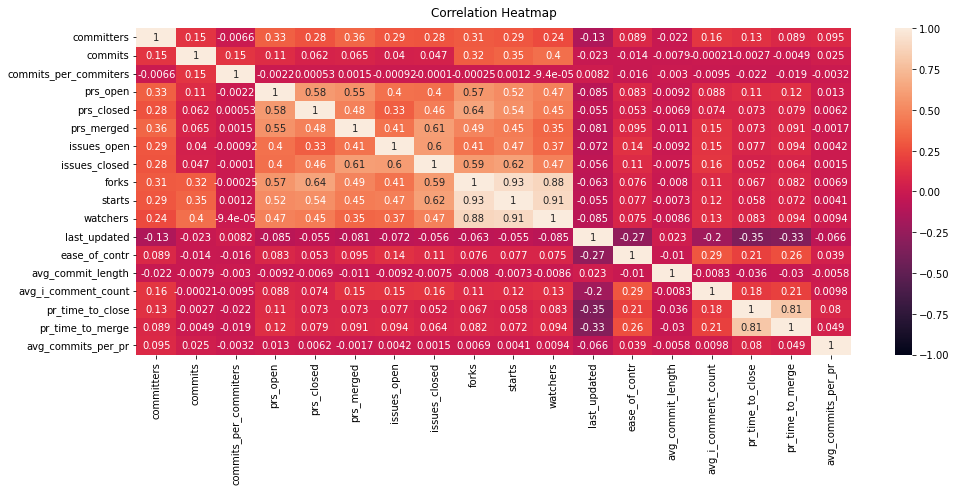

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_repo_set.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Identifying Optimal number of Clusters 

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

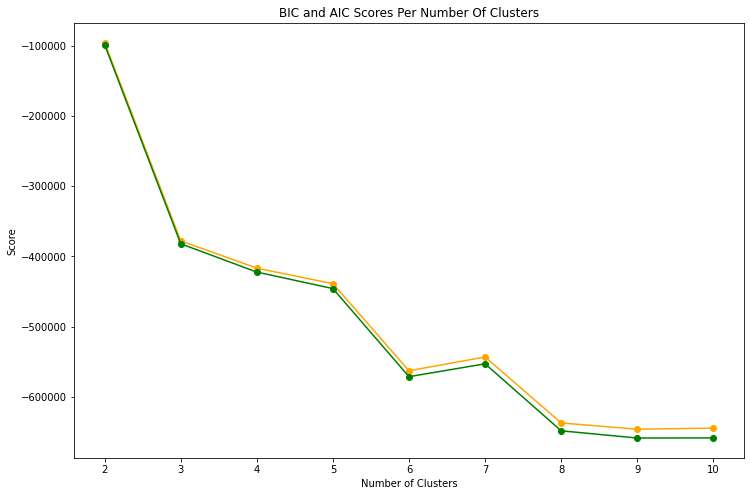

In [15]:
# cluster numbers to try
n_range = range(2,11)

bic_score = [] # Bayesian information criterion
aic_score = [] # Akaike information criterion

for n in n_range:
    gmm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gmm.fit(repo_set)
    
    bic_score.append(gmm.bic(repo_set))
    aic_score.append(gmm.aic(repo_set))
    
# Plot the BIC and AIC 
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

## Scatter Matrix of GMM predictions

Gaussian Mixture Model: [scikit-learn documentation](https://scikit-learn.org/stable/modules/mixture.html)

In [16]:
gmm = GaussianMixture(n_components=4).fit(df_repo_set)
groups = gmm.predict(df_repo_set)

fig = px.scatter_matrix(df_repo_set, title = "GMM predictions with 4 Categories",
            width=1800, height=1800, color=groups)
fig.show()

## Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space to allow us to visualize all 6 dimensions on one plot. 

In [17]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_repo_set)

fig = px.scatter(components, color=groups, title = "GMM predictions with 4 Categories")
fig.show()

In [18]:
pca = PCA(n_components=3)
components = pca.fit_transform(df_repo_set)
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(components,x=0, y=1, z=2, color=groups,title=f'Total Explained Variance: {total_var:.2f}%')
fig.show()

## Magnitude of each feature value

ValueError: ignored

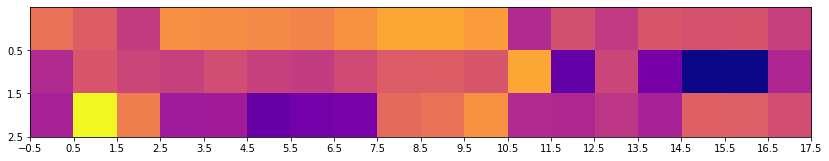

In [58]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')

plt.gca().set_xticks(np.arange(-.5, len(df_repo_set.columns)));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(df_repo_set.columns, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()], pad=0.65);

## Cluster statistics

In [27]:
# generalized version of ^
for color in range(max(groups)+1):
  print("\nCluster #",color)
  c = np.where(groups == color)
  print("Repo count:", len(c[0]))
  print("Cluster statistics:")
  display(repos.iloc[c[0]].describe())
  print("\nRepo examples:")
  for i, y in enumerate(c[0]):
    print(repos.iloc[y].rg_name,":",repos.iloc[y].repo_name)
    if i == 10:
      break


Cluster # 0
Repo count: 4380
Cluster statistics:


repo_group_id       repo_id  last_updated   committers        commits  \
count    4380.000000   4380.000000   4380.000000  4380.000000    4380.000000   
mean    29483.455936  31994.521461    985.960046    13.850457     611.384247   
std     16778.857257   7590.380012    944.746125    41.181853    4803.826481   
min        10.000000  25430.000000     23.000000     0.000000       0.000000   
25%     25444.000000  27280.000000    101.000000     1.000000       3.000000   
50%     25481.000000  30728.500000    619.000000     2.000000      23.000000   
75%     25569.000000  33792.500000   1910.250000     7.000000     161.250000   
max    100119.000000  61713.000000   3719.000000   435.000000  185541.000000   

       commits_per_committer     prs_open   prs_closed   prs_merged  \
count            4380.000000  4380.000000  4380.000000  4380.000000   
mean              187.821918     0.069863     0.045890     0.955251   
std              4523.976524     0.260264     0.279372     2.546988   
min                 0.000000     0.000000     0.000000     0.000000   
25%                 1.000000     0.000000     0.000000     0.000000   
50%                 7.000000     0.000000     0.000000     0.000000   
75%                24.000000     0.000000     0.000000     0.000000   
max            185541.000000     2.000000     6.000000    26.000000   

       open_issues  ...      license          coc        stars     watchers  \
count  4380.000000  ...  4380.000000  4380.000000  4380.000000  4380.000000   
mean      0.037215  ...     0.656849     0.252968     1.504795     7.675342   
std       0.190511  ...     0.474816     0.434762     3.073987     9.339531   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     0.000000     0.000000     0.000000     2.000000   
50%       0.000000  ...     1.000000     0.000000     0.000000     4.000000   
75%       0.000000  ...     1.000000     1.000000     2.000000     9.000000   
max       2.000000  ...     1.000000     1.000000    30.000000    92.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     4380.000000        4380.000000          4380.000000   
mean         0.565068          99.097715             0.004346   
std          0.495805         575.429713             0.047465   
min          0.000000           0.000000             0.000000   
25%          0.000000          14.516304             0.000000   
50%          1.000000          27.275969             0.000000   
75%          1.000000          60.840764             0.000000   
max          1.000000       23345.222222             0.800000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        4380.000000        4380.000000         4380.000000  
mean            1.421611           1.422542            0.337124  
std             3.966270           3.969428            0.721359  
min             0.000000           0.000000            0.000000  
25%             0.000000           0.000000            0.000000  
50%             0.000000           0.000000            0.000000  
75%             0.000000           0.000000            0.000000  
max            23.000000          23.000000            5.000000  

[8 rows x 22 columns]


Repo examples:
Default Repo Group : update-test
Anaconda-Platform : support
Anaconda-Platform : shellingham-feedstock
Anaconda-Platform : python-flatbuffers-feedstock
Anaconda-Platform : transformers-feedstock
Anaconda-Platform : ae5-tini
Anaconda-Platform : ae5-flask
Anaconda-Platform : nbresuse
candlepin : ansible-role-subman-devel
candlepin : candlepin-deps
candlepin : dependencies

Cluster # 1
Repo count: 5372
Cluster statistics:


repo_group_id       repo_id  last_updated   committers      commits  \
count    5372.000000   5372.000000   5372.000000  5372.000000  5372.000000   
mean    34185.524572  34701.464259    280.250000    11.698436   189.610201   
std     23917.411068   9943.978068    475.738224    13.342484   347.503117   
min        10.000000  25434.000000     20.000000     0.000000     0.000000   
25%     25478.000000  29122.250000     33.000000     4.000000     0.000000   
50%     25536.000000  32049.500000     86.000000     7.000000    51.000000   
75%     25597.000000  34748.250000    330.000000    14.000000   205.250000   
max    100119.000000  61724.000000   3708.000000   105.000000  2674.000000   

       commits_per_committer     prs_open   prs_closed   prs_merged  \
count            5372.000000  5372.000000  5372.000000  5372.000000   
mean               16.600521     1.943038    10.298399    56.806031   
std                25.001436     3.377579    18.135502    98.064801   
min                 0.000000     0.000000     0.000000     0.000000   
25%                 0.000000     0.000000     1.000000     3.000000   
50%                 9.000000     1.000000     3.000000    19.000000   
75%                21.000000     2.000000    11.000000    63.000000   
max               226.000000    30.000000   148.000000   786.000000   

       open_issues  ...      license          coc        stars     watchers  \
count  5372.000000  ...  5372.000000  5372.000000  5372.000000  5372.000000   
mean      3.665115  ...     0.754095     0.419025    24.855547    14.896500   
std       7.772296  ...     0.430662     0.493445    49.825975    13.652362   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     1.000000     0.000000     2.000000     6.000000   
50%       0.000000  ...     1.000000     0.000000     6.000000    11.000000   
75%       3.000000  ...     1.000000     1.000000    22.000000    19.000000   
max      62.000000  ...     1.000000     1.000000   561.000000   122.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     5372.000000        5372.000000          5372.000000   
mean         0.765450          67.501855             1.247473   
std          0.423756         248.572267             1.649173   
min          0.000000           0.000000             0.000000   
25%          1.000000          14.292717             0.000000   
50%          1.000000          24.142654             0.689495   
75%          1.000000          54.445713             2.000000   
max          1.000000       10500.893617            15.444444   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        5372.000000        5372.000000         5372.000000  
mean            7.033295           5.959961            1.932446  
std             4.159401           4.257473            2.273056  
min             0.000000           0.000000            0.000000  
25%             4.482582           2.666667            1.000000  
50%             7.113868           6.154626            1.459730  
75%             9.416667           8.682957            2.331800  
max            23.000000          23.000000           22.000000  

[8 rows x 22 columns]


Repo examples:
Default Repo Group : grimoirelab-perceval-opnfv
Default Repo Group : grimoirelab-hatstall
Anaconda-Platform : ae5-prefect
Anaconda-Platform : ae5-tools
Anaconda-Platform : nbbrowserpdf
Anaconda-Platform : s2i-anaconda-project
Anaconda-Platform : chalmers
Anaconda-Platform : pool
Anaconda-Platform : livy-submit
Anaconda-Platform : accord
Anaconda-Platform : nb_conda

Cluster # 2
Repo count: 6
Cluster statistics:


repo_group_id       repo_id  last_updated  committers       commits  \
count       6.000000      6.000000           6.0    6.000000  6.000000e+00   
mean    25514.333333  30434.666667          28.0  319.666667  2.249318e+05   
std        77.935016   3631.241587           0.0  161.672096  4.574930e+05   
min     25456.000000  27784.000000          28.0    0.000000  0.000000e+00   
25%     25462.000000  27960.250000          28.0  335.000000  8.919750e+03   
50%     25477.500000  28474.500000          28.0  369.500000  4.058400e+04   
75%     25547.000000  32601.500000          28.0  401.000000  9.649950e+04   
max     25648.000000  36109.000000          28.0  444.000000  1.154920e+06   

       commits_per_committer    prs_open    prs_closed    prs_merged  \
count               6.000000    6.000000      6.000000      6.000000   
mean               89.333333  393.000000  16385.333333  18946.333333   
std               123.430412  190.464695  14172.470436  21991.299567   
min                 0.000000  212.000000    440.000000      5.000000   
25%                 0.000000  314.750000   6459.250000   1394.750000   
50%                54.500000  334.000000  15104.000000  11780.000000   
75%               110.500000  390.750000  22140.000000  31637.750000   
max               316.000000  760.000000  39601.000000  53923.000000   

       open_issues  ...  license       coc          stars     watchers  \
count     6.000000  ...      6.0  6.000000       6.000000     6.000000   
mean   1255.166667  ...      1.0  0.666667   81680.833333  3552.000000   
std    1484.184950  ...      0.0  0.516398   38763.846886  2305.240291   
min       0.000000  ...      1.0  0.000000   34878.000000  1962.000000   
25%     167.250000  ...      1.0  0.250000   58347.750000  2276.750000   
50%     988.500000  ...      1.0  1.000000   79040.000000  2944.000000   
75%    1509.000000  ...      1.0  1.000000   94906.750000  3190.500000   
max    3978.000000  ...      1.0  1.000000  145481.000000  8135.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count        6.000000           6.000000             6.000000   
mean         0.666667          38.435098             4.984206   
std          0.516398          15.948198             4.133122   
min          0.000000          21.508731             0.000000   
25%          0.250000          25.279568             1.339310   
50%          1.000000          36.261568             6.282780   
75%          1.000000          49.768792             7.315814   
max          1.000000          60.688618             9.988032   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count           6.000000           6.000000            6.000000  
mean            8.893071           9.641558            2.359185  
std             1.786551           0.875894            2.953211  
min             5.489978           8.314922            0.000000  
25%             8.715482           9.134724            0.000000  
50%             9.483840           9.751849            1.300153  
75%            10.100060          10.314247            3.993319  
max            10.135940          10.600000            7.097147  

[8 rows x 22 columns]


Repo examples:
moby : moby
kubernetes : kubernetes
ansible : ansible-2
apache : spark
nodejs : node
torvalds : linux

Cluster # 3
Repo count: 1824
Cluster statistics:


repo_group_id       repo_id  last_updated   committers       commits  \
count    1824.000000   1824.000000   1824.000000  1824.000000  1.824000e+03   
mean    31107.486294  32788.059759    127.413925    99.361842  7.660995e+03   
std     19665.059494   8529.373369    296.217286   106.963093  3.957821e+04   
min     25430.000000  25431.000000     21.000000     0.000000  0.000000e+00   
25%     25458.000000  28117.500000     29.000000    21.000000  0.000000e+00   
50%     25478.000000  30602.500000     32.000000    56.000000  1.019500e+03   
75%     25559.000000  33379.500000     69.250000   139.000000  4.060250e+03   
max    100119.000000  61701.000000   3306.000000   466.000000  1.153508e+06   

       commits_per_committer     prs_open    prs_closed    prs_merged  \
count            1824.000000  1824.000000   1824.000000   1824.000000   
mean               90.480263    17.195724    248.463816    806.607456   
std               352.717656    57.456774    826.555579   2540.145940   
min                 0.000000     0.000000      0.000000      0.000000   
25%                 0.000000     0.000000      6.000000      5.000000   
50%                18.000000     3.000000     49.000000    149.000000   
75%                68.000000    13.000000    183.000000    707.250000   
max             10391.000000   988.000000  13676.000000  48161.000000   

       open_issues  ...      license          coc         stars     watchers  \
count  1824.000000  ...  1824.000000  1824.000000   1824.000000  1824.000000   
mean     57.426535  ...     0.877741     0.529605   1019.518092    69.683114   
std     203.489547  ...     0.327674     0.499260   3510.945429   168.856408   
min       0.000000  ...     0.000000     0.000000      0.000000     0.000000   
25%       0.000000  ...     1.000000     0.000000     17.000000    11.000000   
50%       1.000000  ...     1.000000     1.000000    105.000000    25.000000   
75%      42.000000  ...     1.000000     1.000000    529.250000    60.250000   
max    3957.000000  ...     1.000000     1.000000  54030.000000  3088.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     1824.000000        1824.000000          1824.000000   
mean         0.648575          51.501156             2.104200   
std          0.477546          64.952986             3.188329   
min          0.000000           0.000000             0.000000   
25%          0.000000          17.559329             0.000000   
50%          1.000000          28.630615             1.343287   
75%          1.000000          58.981213             3.346414   
max          1.000000        1039.397781            53.000000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        1824.000000        1824.000000         1824.000000  
mean            7.708640           6.326013            6.938827  
std             3.442849           4.084128           23.267499  
min             0.000000           0.000000            0.000000  
25%             6.064533           3.428755            1.000000  
50%             8.250446           7.288460            1.967685  
75%             9.784448           9.105961            3.814408  
max            23.000000          23.000000          250.000000  

[8 rows x 22 columns]


Repo examples:
Anaconda-Platform : anaconda-project
Anaconda-Platform : nbpresent
candlepin : candlepin
candlepin : subscription-manager
cekit : cekit
CentOS : CentOS-Dockerfiles-1
CentOS : container-pipeline-service
CentOS : sig-cloud-instance-images
cobbler : cobbler-1
eclipse : Xpect
eclipse : xtext


## Sample repo query - finding nearest neighbors

Given a name and organization for a target repo, we want to be able to identify which cluster the repo belongs to and list projects that are most similar to it (based on current set of features).

In [35]:
target_repo = 'kubernetes'
target_rg = 'kubernetes'

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated, 
              r.committers_count as committers,
              r.commit_count as commits,
              CASE WHEN r.committers_count > 0 THEN r.commit_count / r.committers_count ELSE 0 END AS commits_per_committer,
              r.pull_requests_open as prs_open,
              r.pull_requests_closed as prs_closed,
              r.pull_requests_merged as prs_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count as forks,
              r.license_file as license, 
              r.code_of_conduct_file as coc, 
              r.stars_count as stars,
              r.watchers_count as watchers, 
              r.issues_enabled,
              (SELECT AVG(c.cmt_added) FROM commits c WHERE c.repo_id = b.repo_id) AS avg_commit_length,
              (SELECT AVG(i.comment_count) FROM issues i WHERE i.repo_id = b.repo_id) AS avg_i_comment_count,
              AVG(DATE_PART('hour',pr.pr_closed_at - pr.pr_created_at)) as avg_time_to_close,
              AVG(DATE_PART('hour',pr.pr_merged_at - pr.pr_created_at)) as avg_time_to_merge,
              (SELECT AVG(commit_count) AS avg_commits_per_pr
         FROM (SELECT pr.pull_request_id, COUNT(prc.pr_cmt_id) AS commit_count
               FROM pull_request_commits prc
               JOIN pull_requests pr ON prc.pull_request_id = pr.pull_request_id
               WHERE pr.repo_id = b.repo_id
               GROUP BY pr.pull_request_id
              ) AS pr_commits
        ) AS avg_commits_per_pr
          FROM repo_groups a
          JOIN repo b ON a.repo_group_id = b.repo_group_id
          JOIN repo_info r ON r.repo_id = b.repo_id AND r.repo_info_id = (
              SELECT MAX(r2.repo_info_id)
              FROM repo_info r2
              WHERE r2.repo_id = b.repo_id
          )
          LEFT JOIN pull_requests pr ON pr.repo_id = b.repo_id
          WHERE b.repo_name = \'{target_repo}\' AND a.rg_name = \'{target_rg}\'
          GROUP BY
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated,
              r.committers_count,
              r.commit_count,
              r.pull_requests_open,
              r.pull_requests_closed,
              r.pull_requests_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count,
              r.license_file,
              r.code_of_conduct_file,
              r.stars_count,
              r.watchers_count,
              r.issues_enabled

""")
target = pd.read_sql(repo_query, con=engine)
target = target.fillna(0) # change NaN values to 0
display(target)
target.dtypes

rg_name  repo_group_id   repo_name  repo_id        last_updated  \
0  kubernetes          25457  kubernetes    27835 2023-02-01 08:04:51   

   committers  commits  commits_per_committer  prs_open  prs_closed  ...  \
0         359   113503                    316       760       18228  ...   

                                          license  \
0  http://choosealicense.com/licenses/apache-2.0/   

                                                 coc  stars  watchers  \
0  https://github.com/kubernetes/kubernetes/blob/...  95518      3263   

  issues_enabled avg_commit_length  avg_i_comment_count  avg_time_to_close  \
0           true         40.793501             9.988032           9.995523   

  avg_time_to_merge  avg_commits_per_pr  
0          9.923655            2.600306  

[1 rows x 24 columns]

rg_name                          object
repo_group_id                     int64
repo_name                        object
repo_id                           int64
last_updated             datetime64[ns]
committers                        int64
commits                           int64
commits_per_committer             int64
prs_open                          int64
prs_closed                        int64
prs_merged                        int64
open_issues                       int64
issues_closed                     int64
forks                             int64
license                          object
coc                              object
stars                             int64
watchers                          int64
issues_enabled                   object
avg_commit_length               float64
avg_i_comment_count             float64
avg_time_to_close               float64
avg_time_to_merge               float64
avg_commits_per_pr              float64
dtype: object

In [36]:
# issues_enabled object to bool int
target.issues_enabled.loc[target.issues_enabled == 'true'] = 1
target.issues_enabled.loc[target.issues_enabled == 'false'] = 0
target.issues_enabled = target.issues_enabled.astype(int)

# days since last update
now = datetime.datetime.now()
target.last_updated.apply(lambda d: pd.to_datetime(str(d)))
target.last_updated = (now - target.last_updated).astype('timedelta64[D]')
target.last_updated = target.last_updated.astype(int)

# object to binary int for licence and coc
target.license.loc[target.license != 0] = 1
target.coc.loc[target.coc != 0] = 1

target.license = target.license.astype(int)
target.coc = target.coc.astype(int)

target_set = []
target_set = np.array([target.committers, target.commits, target.commits_per_committer, target.prs_open, 
                     target.prs_closed, target.prs_merged, target.open_issues, target.issues_closed, 
                     target.forks, target.stars, target.watchers, target.last_updated, 
                     (target.license + target.coc + target.issues_enabled), target.avg_commit_length, 
                     target.avg_i_comment_count, target.avg_time_to_close, target.avg_time_to_merge, 
                     target.avg_commits_per_pr]).astype(np.int64).transpose()


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# norm (unit var and zero mean)
#scaler = pp.StandardScaler().fit(repo_set)
target_set = scaler.transform(target_set)

df_target = pd.DataFrame(target_set, columns = ["committers","commits","commits_per_commiters","prs_open",
                 "prs_closed", "prs_merged", "issues_open","issues_closed", "forks", "starts", "watchers", 
                 "last_updated", "ease_of_contr", "avg_commit_length","avg_i_comment_count", "pr_time_to_close", 
                 "pr_time_to_merge", "avg_commits_per_pr"])

print(df_target)

   committers   commits  commits_per_commiters   prs_open  prs_closed  \
0    5.558589  5.748886               0.080023  29.563972   31.147644   

   prs_merged  issues_open  issues_closed      forks     starts   watchers  \
0    44.01184    16.766309      53.764727  39.374628  38.385877  27.568525   

   last_updated  ease_of_contr  avg_commit_length  avg_i_comment_count  \
0     -0.644681       1.584008           -0.09263             4.709018   

   pr_time_to_close  pr_time_to_merge  avg_commits_per_pr  
0          0.896684          1.085131            0.008547  


In [57]:
d = repo_set - target_set
distances = np.linalg.norm(d,axis = 1)

k = 10
nn_ids = distances.argsort()[:k]
print("Cluster of target repo: ",gmm.predict(df_target))
print("\nMost similar repos:")
for repo in nn_ids:
    print(repos.iloc[repo].rg_name,":",repos.iloc[repo].repo_name)

Cluster of target repo:  [2]

Most similar repos:
kubernetes : kubernetes
ansible : ansible-2
nodejs : node
moby : moby
istio : istio
apache : echarts
apache : superset
kubernetes : website
apache : airflow
apache : dubbo
